## SEIRS Model - Adaptive Iterative Sequential Data-Consistent Parameter Estimation 

**Problem description**:

The SEIRS model describes the spread of a disease in a population fixed to $N$ individuals over time $t$. Furthermore, the model divides the population into four categories, called "S", "E", "I", and "R". The extra "S" at the end usually means we include the loss of immunity.
- "S" consists of individuals who are susceptible to the disease being modeled.
- "E" consists of individuals who are exposed to the disease. Diseases (like COVID-19) often have an incubation period or a latency period and this category accommodates it. (The SIR model does not have this category.)
- "I" consists of individuals infected with the disease and are capable of infecting others.
- "R" consists of individuals who can be removed from the system, e.g., because they have gained immunity to the disease, or because they have succumbed to the disease.

The SEIR model, like many other epidemiological models depends on particular parameters, which are the following :
 - $\beta>0$ The rate of contraction of the disease (transmission parameter)
 - $ \sigma >0$ The incubation rate i.e. the rate at which exposed hosts become infected
 - $\gamma>0$ : The mean recovery rate
 - $\xi>0$ : The loss of immunity rate. 
 
Individual $S$ becomes infected after positive contact with an $I$ individual. However, he develops immunity to the disease : he leaves $I$ category at a $\gamma$ cure rate. However with a rate $\xi$, they may lose immunity to the disease and rejoin the susceptible population $S$.

**Model Assumptions**

- Model is deterministic
- On average, an individual $S$ in the population encounters $\beta$ individuals per unit time.
- The rate of infected individuals leaving category $I$ is $\gamma I$ per unit time (once an individual has been infected, he develops immunity to the disease).
- The population size $N=S+E+I+R$ is constant.
- Note constant average number of contacts $\beta$ is a strong and constraining assumption : it cannot be applied to all diseases.

This is the system of equations of the model :

The total population $N$ in the system (the sum of individuals in all categories) is likely to be quite large. Instead of working with such large numbers, let us divide each side of each equation by $\mathbf{N}$ and work instead with the proportions
$$
s=\frac{S}{N}, \quad e=\frac{E}{N}, \quad i=\frac{I}{N}, \quad r=\frac{R}{N} .
$$
The equivalent ODE system to be solved for the unknown functions $s(t), e(t), i(t)$, and $r(t)$, has now become
$$
\begin{aligned}
& \frac{d s}{d t}=-\beta i s  + \xi r\\
& \frac{d e}{d t}=\beta i s-\sigma e \\
& \frac{d i}{d t}=\sigma e-\gamma i \\
& \frac{d r}{d t}=\gamma i - \xi r
\end{aligned}
$$
When supplemented with some initial conditions, say
$$
s(0)=0.99, \quad e(0)=0.01, \quad i(0)=0, \quad r(0)=0
$$
This is the formulation of the Initial Value Probelm we wish to solve. Note that the above initial conditions correspond to a starting scenario where just $1 \%$ of the population is exposed.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pydci.examples import seirs
import importlib
from pydci.log import enable_log, disable_log
from pydci.utils import get_l2_errs, set_seed

importlib.reload(seirs)


SEIRS_PARAM_MINS = 4 * [0]
SEIRS_STATE_MINS = 1e-10
SEIRS_STATE_MAXS = 1

# For periodic behavior
R_0 = 3

# Sample every week
SEIRS_SAMPLE_TS = 1

# Populations are all from 0-1 -> Fraction of population
SEIRS_NOISE = 0.001

# Parameters from bjornstad2020seirs paper
SEIRS_P1 = [
    R_0 / 14.0,  # beta transmission rate - R_0 / gamma -> R_0 > 0 for periodic behavior
    1.0 / 7.0,  # sigma incubation rate i.e. rate at which exposed hosts become infected - 1 week
    1.0 / 14.0,  # gamma  mean recovery rate - 2 weeks
    1.0 / 365.0,  # xi - loss off imunity rate - 1 year
]

# (1) Policy Lockdown 1 month in: => Slower Transmission Rate(beta) - Time 75
SEIRS_P2 = [
    0.5 * R_0 / 14.0,  # transmission rate halved
    1.0 / 7.0,  # sigm
    1.0 / 14.0,
    1.0 / 365.0,
]
# (2) Virus Mutation 1 year in: => Faster Incubation Rate (sigma) - Time 150
SEIRS_P3 = [
    1.2 * R_0 / 14.0,  # transmission rate increased -> Faster transmitting virus
    1.0 / 3.5,  # Incubation rate halved -> Exposed hosts become infected quicker
    1.0 / 14.0,
    1.0 / 365.0,
]

SEIRS_X0 = [
    0.98,  # susceptible
    0.010,  # exposed
    0.010,  # infected
    0,  # recovered
]

# enable_log(level='DEBUG')
n_samples = 1000
total_time = 1 * 365.25
param_shifts = {0: SEIRS_P1, 25: SEIRS_P2, 150: SEIRS_P3}

## Problem Set-Up

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

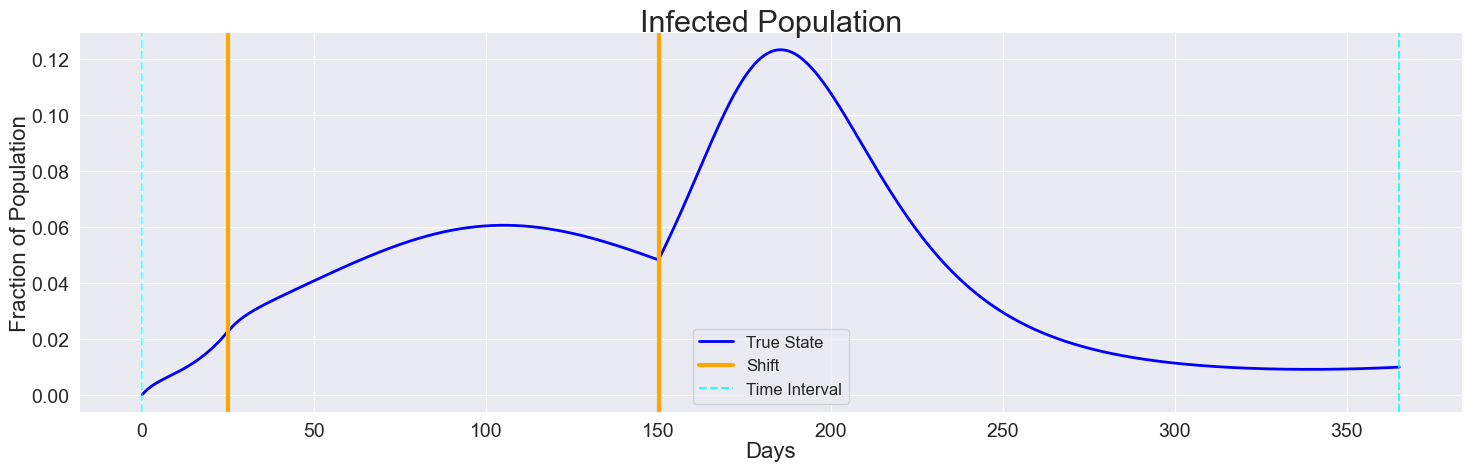

In [2]:
full_sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)
# pi_in, samples = full_sr.get_uniform_initial_samples(num_samples=1, scale=0.1)
res = full_sr.get_data(t0=0.0, tf=total_time)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
full_sr.plot_infected(plot_samples=False, plot_measurements=False, ax=ax)

# Online Iterative

In [3]:
total_time = 1 * 365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=2*SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)

In [4]:
from pydci.log import logger
from pydci.utils import get_search_combinations
import pydci.consistent_bayes.OnlineSequential as os
import importlib

importlib.reload(os)
prob = os.OnlineSequential(
    sr,
    time_step=7,
)
enable_log(level='DEBUG', filter='pydci.consistent_bayes.OnlineSequential', file='seirs_adaptive_iterative.log')
prob.solve(
    num_its=52,
    max_t=None,
    num_samples=1000,
    max_sample_size=2000,
    samples_inc=None,
    time_step=7,
    exp_thresh=0.1,
    kl_thresh=3.0,
    min_eff_sample_size=0.5,
    num_tries_per_it=2,
    sampling_args={
        "dist": "uniform",
        "scale": 1.0,
    },
    solver_args=dict(
        pca_range=[1, 2, 3, 4],
        split_range=[1],
        all_data=True,
    ),
    make_plots=False,
    seed=21,
    reset_model=True,
    reset_samples=False,
)

<AxesSubplot: title={'center': 'Infected Population'}, xlabel='Days', ylabel='Fraction of Population'>

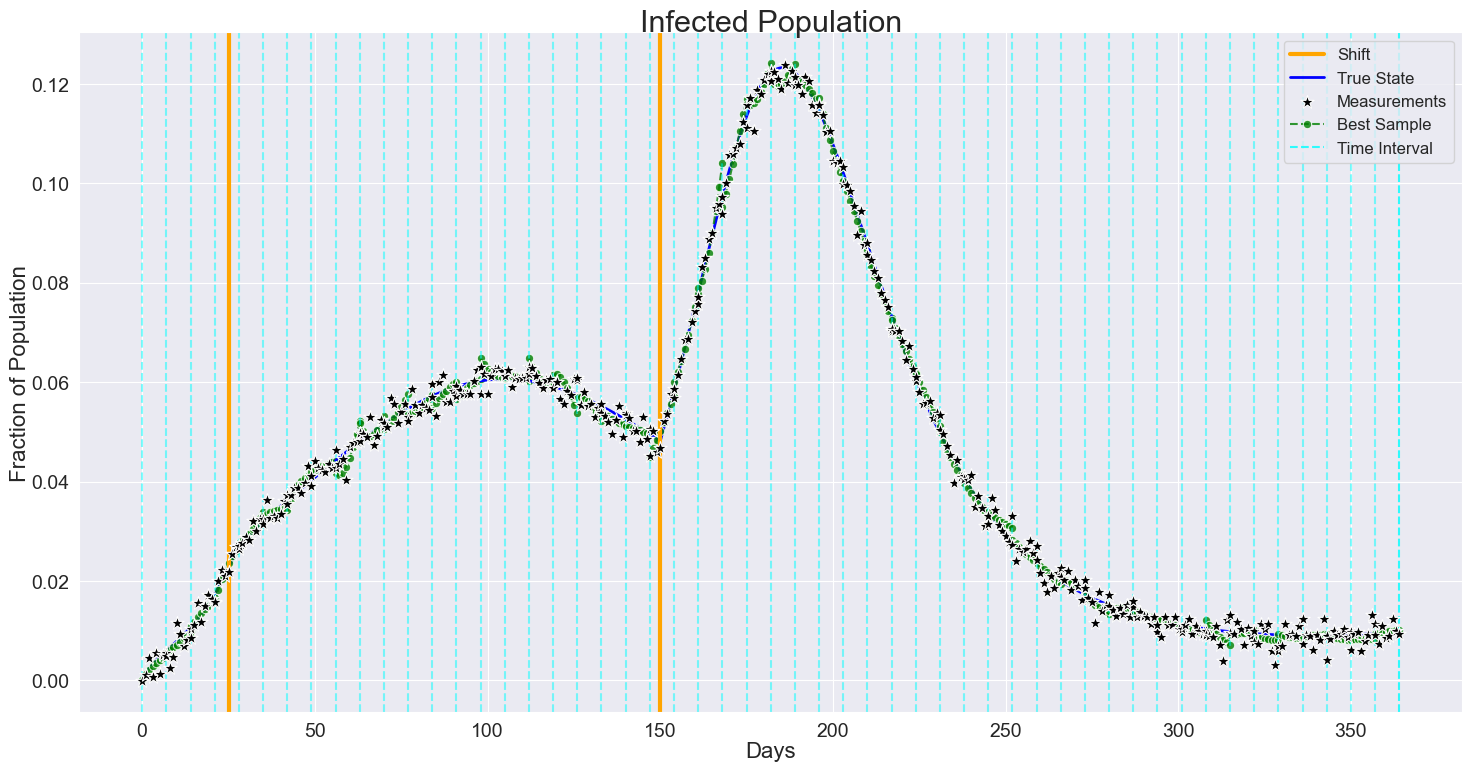

In [5]:
prob.model.plot_infected(figsize=(15,8), n_samples=0)

# First Shift

In [6]:
first_shift = [0, 80]

(-0.006312622272582638, 0.08)

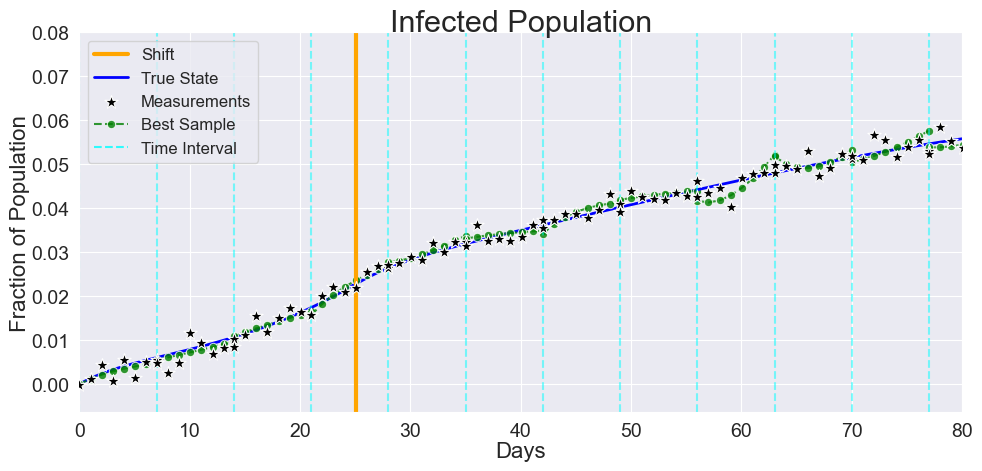

In [7]:
ax = sr.plot_infected(plot_samples=True, n_samples=0, figsize=(10, 5))
ax.set_xlim(first_shift)
ax.set_ylim([ax.get_ylim()[0], 0.08])

In [8]:
prob.results[prob.results['data_idx'] == 5]

,e_r,kl,k_eff,k_eff_up,solved,error,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,...,predict_delta,within_thresh,valid,closest,max_kl,min_kl,num_samples,weighted,data_idx,shift
0,0.970013,1.976397,0.702,0.183,True,None,0.034987,0.095974,0.023366,-0.001616,...,0.029987,True,True,False,False,True,1000,True,5,False
0,0.978348,2.222416,0.702,0.179,True,None,0.090426,0.179137,0.076770,-0.000268,...,0.021652,True,True,True,True,False,1000,True,5,False
0,0.100976,2.212094,0.702,0.173,False,Failed to solve problem on iteration 1 - |E(r)...,0.118579,0.257259,0.100466,0.003729,...,0.899024,False,False,False,False,False,1000,True,5,False
0,0.000569,2.363085,0.702,0.150,False,Failed to solve problem on iteration 1 - |E(r)...,0.118579,0.257259,0.100466,0.003729,...,0.999431,False,False,False,False,False,1000,True,5,False


<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

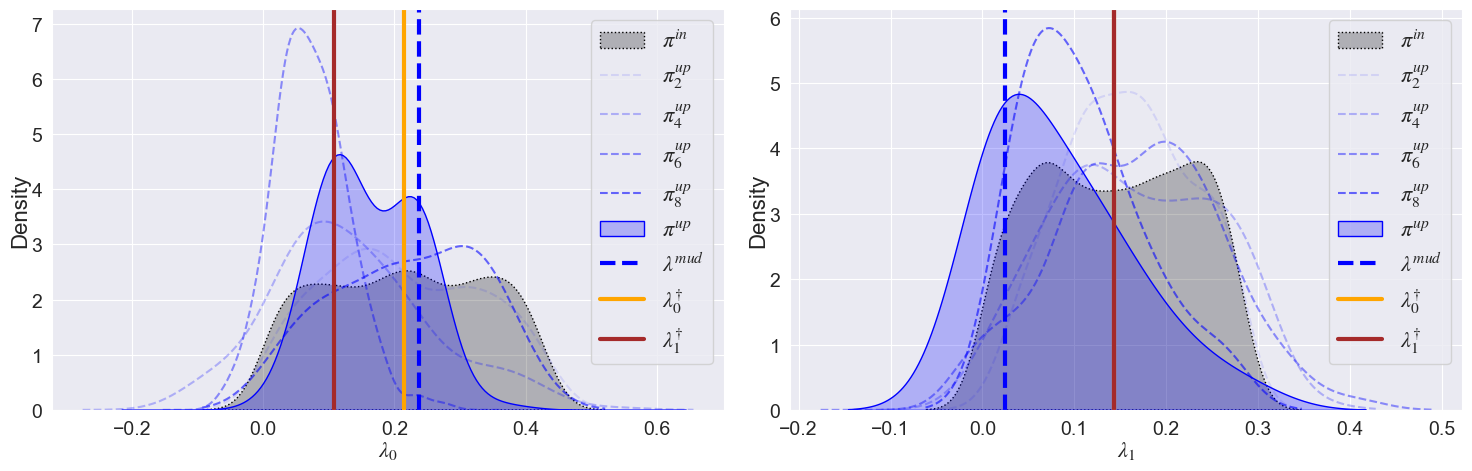

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
prob.plot_param_density(
    [p.best for p in prob.probs],
    param_idx=0,
    idxs=np.arange(0, int(first_shift[1] / 7), 2),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[0],
)
prob.plot_param_density(
    [p.best for p in prob.probs],
    param_idx=1,
    idxs=np.arange(0, int(first_shift[1]/ 7), 2),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[1],
)

# Second Shift

In [18]:
prob.it_results[22]['e_r'].mean(), prob.it_results[22]['kl'].mean()

(0.6384046042366076, 3.444934815794766)

In [19]:
prob.it_results[22]

,e_r,kl,k_eff,k_eff_up,solved,error,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,...,predict_delta,within_thresh,valid,closest,max_kl,min_kl,num_samples,weighted,data_idx,shift
0,1.156793,1.788128,1.0,0.367000,False,Failed to solve problem on iteration 1 - |E(r)...,0.055207,0.193697,0.058942,0.003944,...,0.156793,True,False,False,False,False,1000,False,21,False
0,0.791189,3.455970,1.0,0.320000,False,Failed to solve problem on iteration 1 - |E(r)...,0.245963,0.260863,0.080047,0.001723,...,0.208811,True,False,False,False,False,1000,False,21,False
0,0.495246,3.913486,1.0,0.275000,False,Failed to solve problem on iteration 1 - |E(r)...,0.245963,0.260863,0.080047,0.001723,...,0.504754,False,False,False,False,False,1000,False,21,False
0,0.007997,4.418417,1.0,0.233000,False,Failed to solve problem on iteration 1 - |E(r)...,0.348270,0.158777,0.075752,0.005075,...,0.992003,False,False,False,False,False,1000,False,21,False
0,1.104090,1.856284,1.0,0.364545,False,Failed to solve problem on iteration 1 - |E(r)...,0.173439,0.043934,0.019527,0.003929,...,0.104090,True,False,False,False,False,1100,False,21,False
0,0.914081,3.534048,1.0,0.319091,True,None,0.245963,0.260863,0.080047,0.001723,...,0.085919,True,True,True,False,False,1100,False,21,False
0,0.629578,4.062312,1.0,0.275455,False,Failed to solve problem on iteration 1 - |E(r)...,0.245963,0.260863,0.080047,0.001723,...,0.370422,True,False,False,False,False,1100,False,21,False
0,0.008263,4.530833,1.0,0.230000,False,Failed to solve problem on iteration 1 - |E(r)...,0.348270,0.158777,0.075752,0.005075,...,0.991737,False,False,False,False,False,1100,False,21,False


In [10]:
second_shift = [120, 200]

(-0.006312622272582638, 0.15)

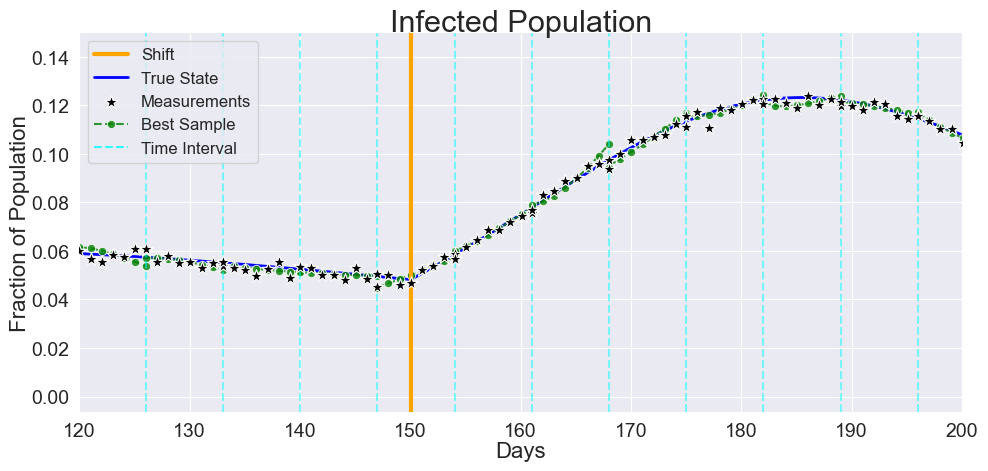

In [12]:
ax = sr.plot_infected(plot_samples=True, n_samples=0, figsize=(10, 5))
ax.set_xlim(second_shift)
ax.set_ylim([ax.get_ylim()[0], 0.15])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

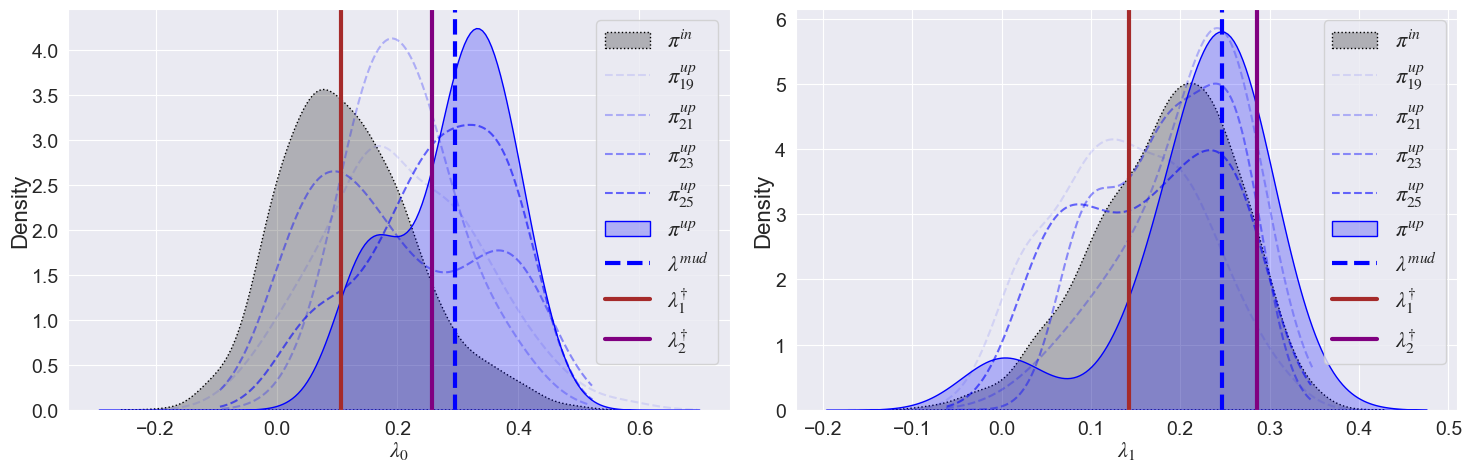

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
prob.plot_param_density(
    [p.best for p in prob.probs],
    param_idx=0,
    idxs=np.arange(int(second_shift[0]/ 7), int(second_shift[1]/ 7), 2),
    lam_true=[(1, SEIRS_P2), (2, SEIRS_P3)],
    ax=axs[0],
)
prob.plot_param_density(
    [p.best for p in prob.probs],
    param_idx=1,
    idxs=np.arange(int(second_shift[0]/ 7), int(second_shift[1]/ 7), 2),
    lam_true=[(1, SEIRS_P2), (2, SEIRS_P3)],
    ax=axs[1],
)

## Adaptive sampling performance when there is a shift

Note:
- We increase the value of e_r but can never get close to 1.0 because of shift.
- KL value decreases with more samples, but always way above threshold of 3

In [10]:
prob.it_results[22]

,e_r,kl,k_eff,k_eff_up,solved,error,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,...,predict_delta,within_thresh,valid,closest,max_kl,min_kl,num_samples,weighted,data_idx,shift
0,1.031934,0.878914,1.0,0.835000,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.031934,True,False,False,False,False,1000,False,13,False
0,0.965091,2.684978,1.0,0.748000,False,Failed to solve problem on iteration 1 - |E(r)...,0.078566,0.203478,0.092068,0.003184,...,0.034909,True,False,False,False,False,1000,False,13,False
0,1.033018,0.889586,1.0,0.835455,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.033018,True,False,False,False,False,1100,False,13,False
0,0.959752,2.657660,1.0,0.743636,False,Failed to solve problem on iteration 1 - |E(r)...,0.078566,0.203478,0.092068,0.003184,...,0.040248,True,False,False,False,False,1100,False,13,False
0,1.034993,0.877245,1.0,0.838333,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.034993,True,False,False,False,False,1200,False,13,False
0,0.981481,2.566763,1.0,0.746667,False,Failed to solve problem on iteration 1 - |E(r)...,0.078566,0.203478,0.092068,0.003184,...,0.018519,True,False,False,False,False,1200,False,13,False
0,1.039089,0.832142,1.0,0.840000,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.039089,True,False,False,False,False,1300,False,13,False
0,0.977401,2.525440,1.0,0.749231,False,Failed to solve problem on iteration 1 - |E(r)...,0.078566,0.203478,0.092068,0.003184,...,0.022599,True,False,False,False,False,1300,False,13,False
0,1.032899,0.846212,1.0,0.839286,False,Failed to solve problem on iteration 1 - |E(r)...,0.092241,0.116941,0.054465,0.003924,...,0.032899,True,False,False,False,False,1400,False,13,False
0,0.975223,2.527130,1.0,0.750000,False,Failed to solve problem on iteration 1 - |E(r)...,0.083385,0.149207,0.072411,0.004574,...,0.024777,True,False,False,False,False,1400,False,13,False


<AxesSubplot: xlabel='num_samples', ylabel='kl'>

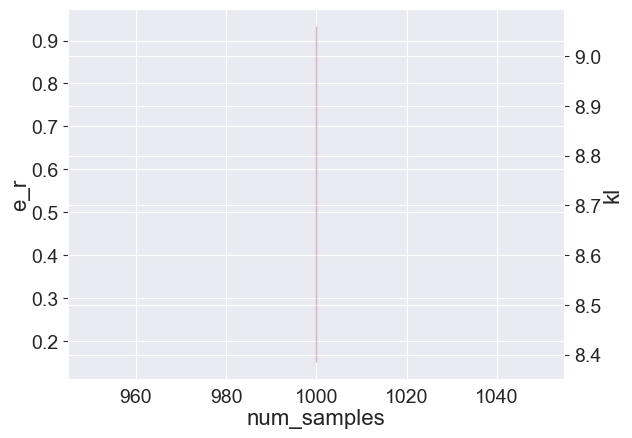

In [29]:
import seaborn as sns
ax = sns.lineplot(prob.it_results[22], x='num_samples', y='e_r')
ax2 = ax.twinx()
sns.lineplot(prob.it_results[22], x='num_samples', y='kl', ax=ax2, color='red')

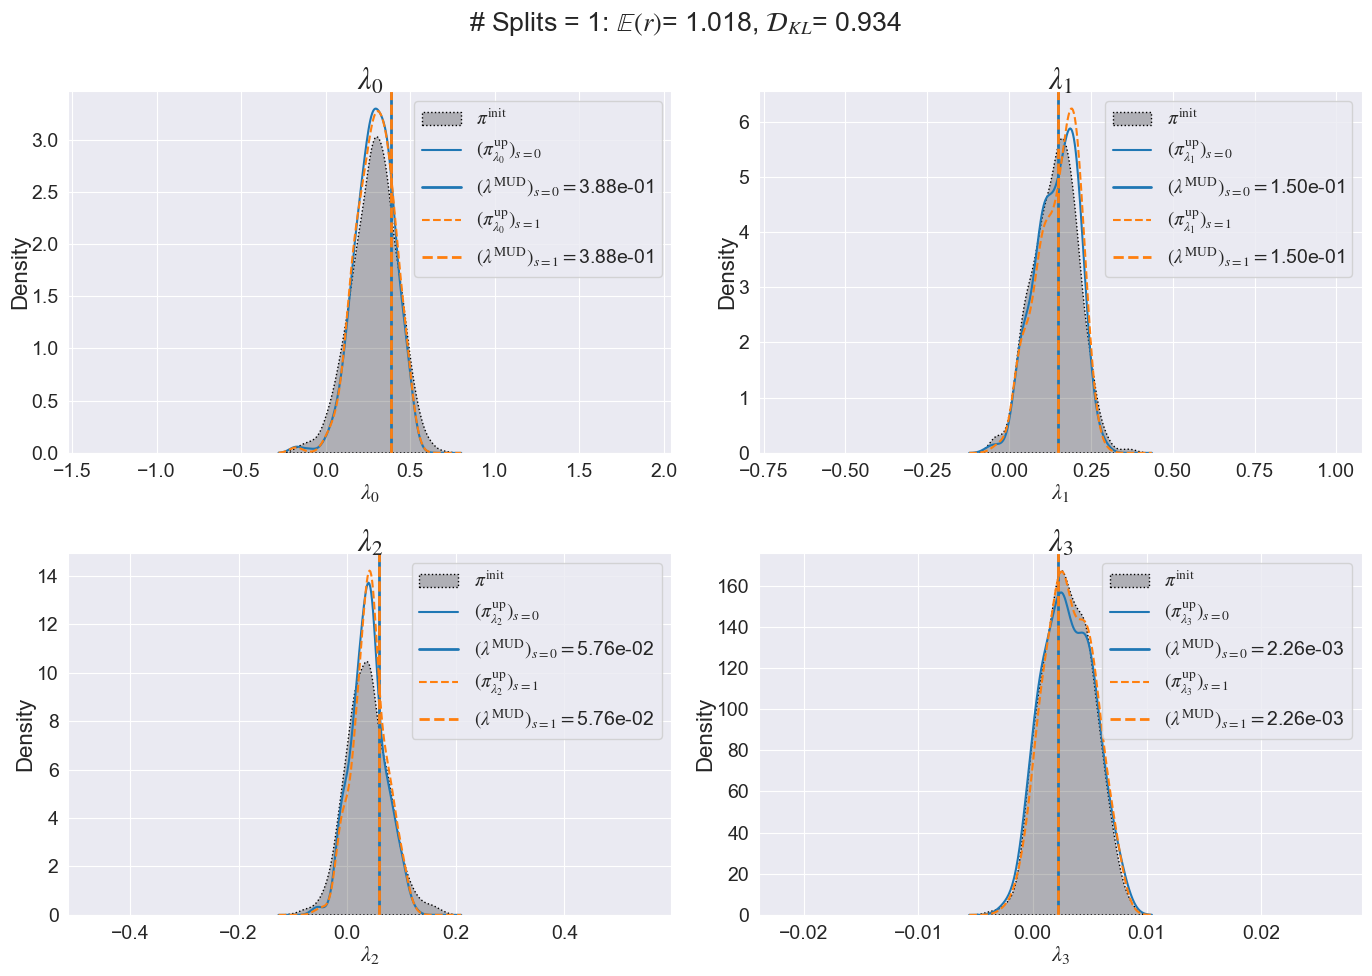

In [13]:
prob.probs[23].param_density_plots()

# OLD Code:

In [86]:
total_time = 1 * 365.25
max_nc = 1
data_chunk_size = 7
n_chunks = int(total_time / data_chunk_size)

sr = seirs.SEIRSModel(
    lam_true=SEIRS_P1,
    param_shifts=param_shifts,
    measurement_noise=SEIRS_NOISE,
    sample_ts=SEIRS_SAMPLE_TS,
    state_mins=SEIRS_STATE_MINS,
    state_maxs=SEIRS_STATE_MAXS,
)


set_seed(21)  # works well
# set_seed(2023) # Does not... why?
sgs, probs = sr.adaptive_online_iterative(
    np.arange(0, data_chunk_size * n_chunks + 1, data_chunk_size),
    diff=1.0,
    num_samples=1000,
    nc=1,
    resample_thresh=0.2,
    shift_thresh=0.5,
    min_eff_sample_size=0.8,
    weights=None,
)

Solving model sample set: |████▋               | ▂▄▆ 230/1000 [23%] in 0s (~0s, 

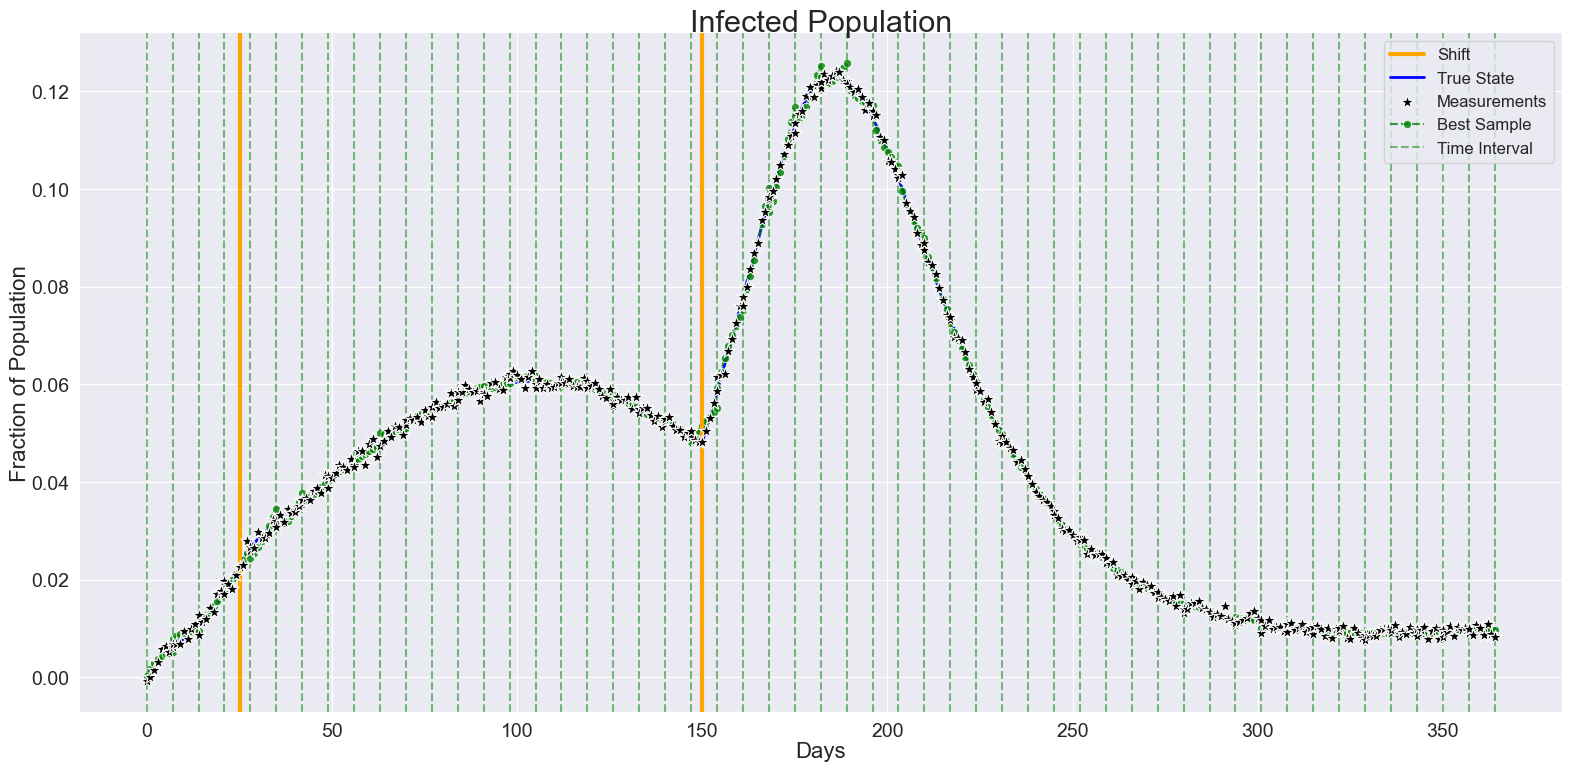

In [93]:
ax = sr.plot_infected(
    plot_measurements=True, plot_samples=True, n_samples=0, figsize=(16, 8)
)

## First Shift - "Flattening of the Curve"

In [88]:
first_shift_end = 100

(-0.007089759073479672, 0.08)

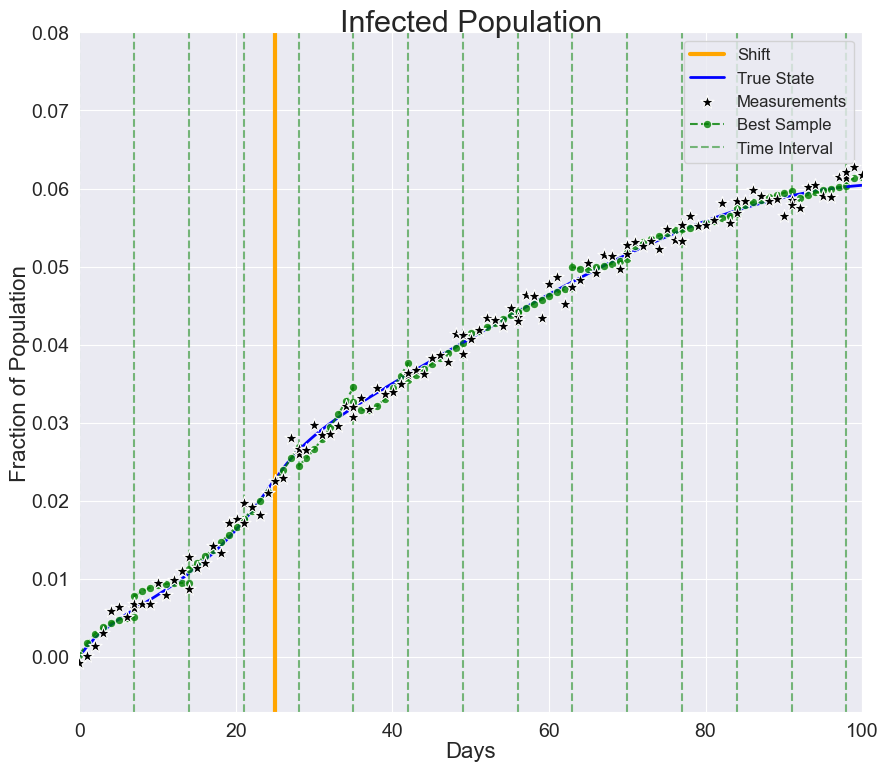

In [89]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([0, first_shift_end])
ax.set_ylim([ax.get_ylim()[0], 0.08])

<AxesSubplot: xlabel='$\\lambda_1$', ylabel='Density'>

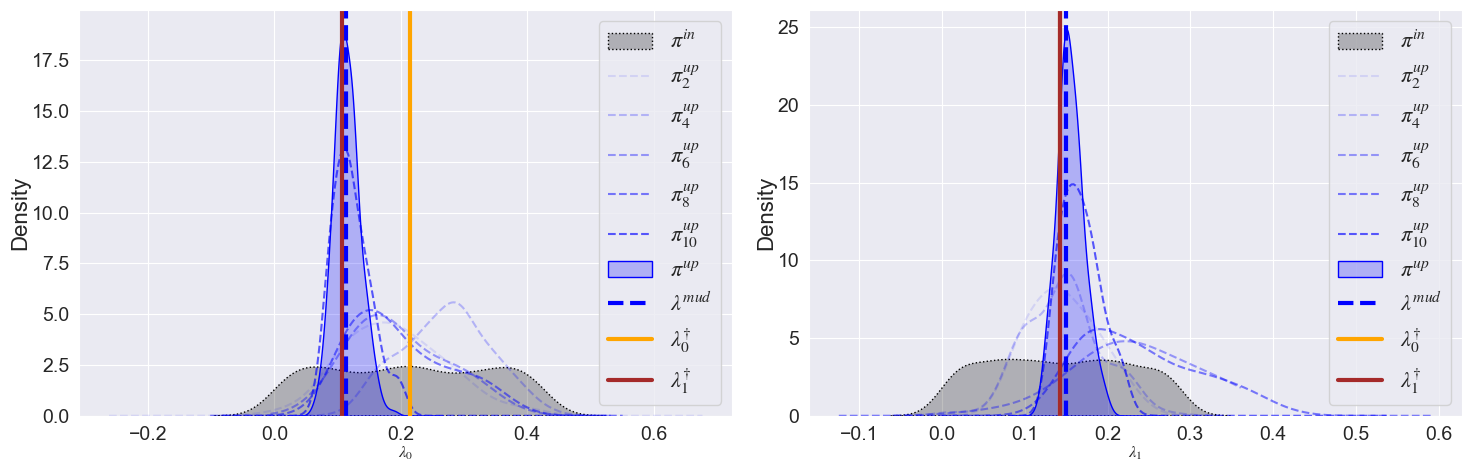

In [90]:
# TODO - Legend for parameter shift  ->
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sr.plot_param_density(
    probs,
    param_idx=0,
    idxs=np.arange(0, int(first_shift_end / 7), 2),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[0],
)
sr.plot_param_density(
    probs,
    param_idx=1,
    idxs=np.arange(0, int(first_shift_end / 7), 2),
    lam_true=[(0, SEIRS_P1), (1, SEIRS_P2)],
    ax=axs[1],
)

## Second Shift - Mutation and "Second wave"

(120.0, 190.0)

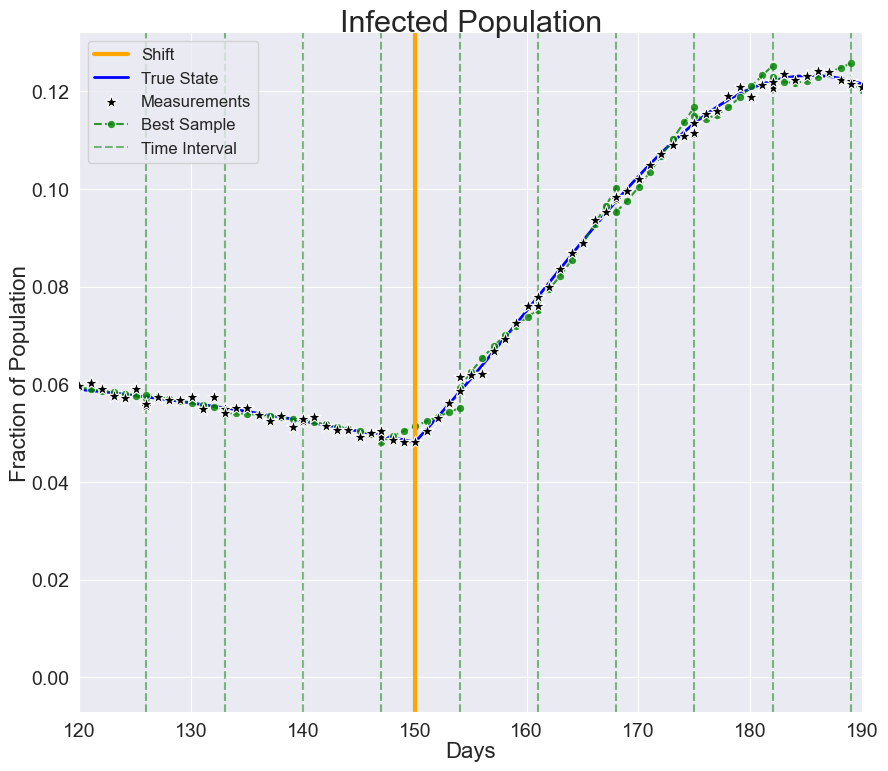

In [82]:
ax = sr.plot_infected(plot_samples=True, n_samples=0)
ax.set_xlim([120, 190])